In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import os
import zipfile
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


import numpy as np
from PIL import Image
import pickle
import cv2

Using TensorFlow backend.


In [2]:
!wget http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip

--2018-11-19 18:50:12--  http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip
Resolving www.iapr-tc11.org (www.iapr-tc11.org)... 157.16.221.56
Connecting to www.iapr-tc11.org (www.iapr-tc11.org)|157.16.221.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245154271 (234M) [application/zip]
Saving to: ‘sigComp2011-trainingSet.zip’

sigComp2011-trainin 100%[=====================>] 233.80M  5.32MB/s   in 54s    s

2018-11-19 18:51:07 (4.32 MB/s) - ‘sigComp2011-trainingSet.zip’ saved [245154271/245154271]



In [3]:
zip_ref = zipfile.ZipFile('sigComp2011-trainingSet.zip', 'r')
zip_ref.extractall(pwd=b'I hereby accept the SigComp 2011 disclaimer.')
zip_ref.close()

In [4]:
def Center(img, new_height, new_width):
    cImg = 255*np.ones((new_height,new_width,3))
    width =  np.size(img,1)
    height = np.size(img,0)

    left = int((new_width - width)/2.)
    top = int(((new_height - height)/2.))
    right = int(((width + new_width)/2.))
    bottom = int(((height + new_height)/2.))
    cImg[top:bottom, left:right,:] = img
    return cImg

In [5]:
x = []
y = []

j = k = 1
arr = []
path = os.listdir('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/')
path.sort(key=str.lower)

for i in range(len(path)):
    if(path[i][2] == str(j)):
        img = cv2.imread('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/'+path[i]+'')
        #img  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        a = np.asarray(img)
        a = Center(a,551,1117)
        x.append(a)
        y1 = np.zeros((10))
        y1[j-1] = 1
        y.append(y1)
        k =k + 1
    elif(j<10):
        j = j + 1
        print('j='+str(j))
    else:
        img = cv2.imread('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/'+path[i]+'')
        #img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        a = np.asarray(img)
        a = Center(a,551,1117)
        x.append(a)
        y1 = np.zeros((10))
        y1[j-1] = 1
        y.append(y1)
        k =k+1

j=2
j=3
j=4
j=5
j=6
j=7
j=8
j=9
j=10


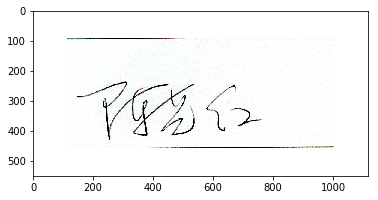

In [6]:
from matplotlib import pyplot as plt
plt.imshow(np.uint8(x[0]))
plt.show()

In [7]:
x = []

a = b = 0 
path = os.listdir('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/')
path.sort(key = str.lower)

for i in range(10):
  y = []
  for j in range(b,len(path)):
    if(path[j][3:6] == str(i+1).zfill(2)):
        img = cv2.imread('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/'+path[j]+'')
        #img  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        arr = np.asarray(img)
        arr = Center(arr,551,1117)
        y.append(arr)
        a = a + 1
        print(a)
        if(a==235):
          x.append(y)
    else:
      print('...............')
      x.append(y)
      b = a
      break

...............
...............
...............
...............
...............
...............
...............
...............
...............
...............


In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [16]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [17]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [18]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))